# CPSC 5616 Machine Learning and Deep Learning

k-NN exercise with Glass Identification Database

# Dataset:

Title: Glass Identification Database

Sources:
    (a) Creator: B. German
        -- Central Research Establishment
           Home Office Forensic Science Service
           Aldermaston, Reading, Berkshire RG7 4PN
    (b) Donor: Vina Spiehler, Ph.D., DABFT
               Diagnostic Products Corporation
               (213) 776-0180 (ext 3014)
    (c) Date: September, 1987

Relevant Information:

The study of classification of types of glass was motivated by criminological investigation.  At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!

Number of Instances: 214

Number of Attributes: 10 (including an Id#) plus the class attribute
   -- all attributes are continuously valued

Attribute Information:
   1. Id number: 1 to 214
   2. RI: refractive index
   3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
   4. Mg: Magnesium
   5. Al: Aluminum
   6. Si: Silicon
   7. K: Potassium
   8. Ca: Calcium
   9. Ba: Barium
  10. Fe: Iron
  11. Type of glass: (class attribute)
      -- 1 building_windows_float_processed
      -- 2 building_windows_non_float_processed
      -- 3 vehicle_windows_float_processed
      -- 4 vehicle_windows_non_float_processed (none in this database)
      -- 5 containers
      -- 6 tableware
      -- 7 headlamps

Missing Attribute Values: None

Class Distribution: (out of 214 total instances)
    -- 163 Window glass (building windows and vehicle windows)
    -- 87 float processed  
    -- 70 building windows
    -- 17 vehicle windows
    -- 76 non-float processed
    -- 76 building windows
    -- 0 vehicle windows
    -- 51 Non-window glass
    -- 13 containers
    -- 9 tableware
    -- 29 headlamps

Source: UCI Machine Learning Repository https://archive.ics.uci.edu/dataset/42/glass+identification


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

Upload the your CSV file to your Google Drive. Mount your Google Drive in Colab by running the following code

It will prompt you to authorize Colab to access your Google Drive. Follow the instructions and enter the authorization code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load the CSV file into a Pandas dataframe. You need to replace filename with the actual path to your CSV file in Google Drive.

In [ ]:
#filename = ('/content/drive/MyDrive/LU/Teaching/CPSC 5616EL: Machine Learning, and Deep Learning/Notebooks/glass/glass.data')
filename = ('/content/drive/MyDrive/Colab Notebooks/glass.data')
cols = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "class"]
df = pd.read_csv(filename, names=cols)
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


# Histrogram

Plots histragrams based on their elements for each of the classes

[1 2 3 5 6 7]


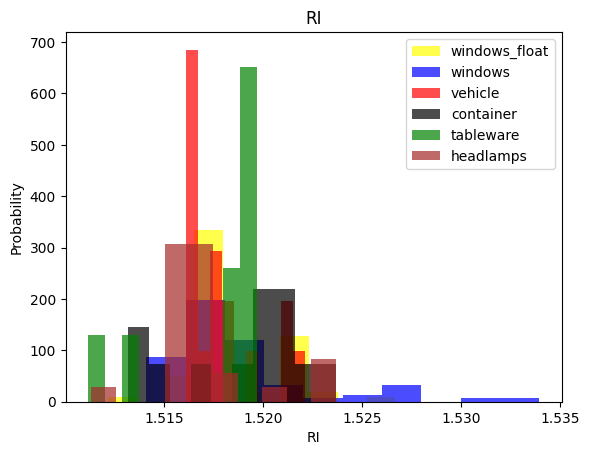

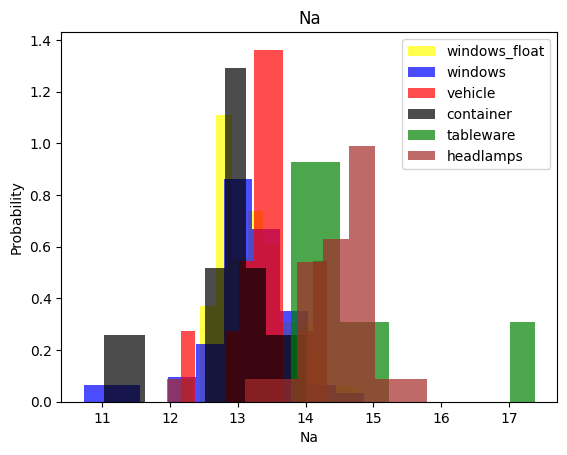

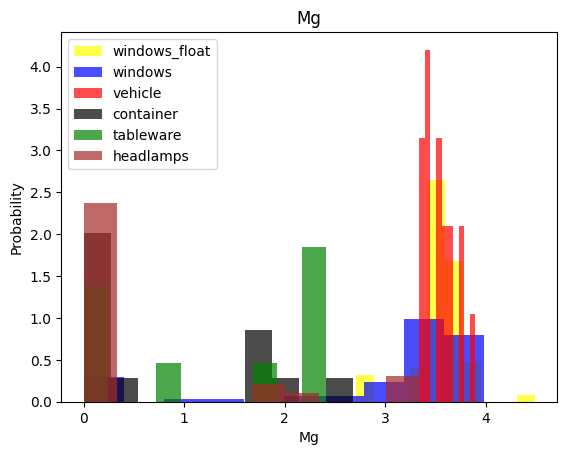

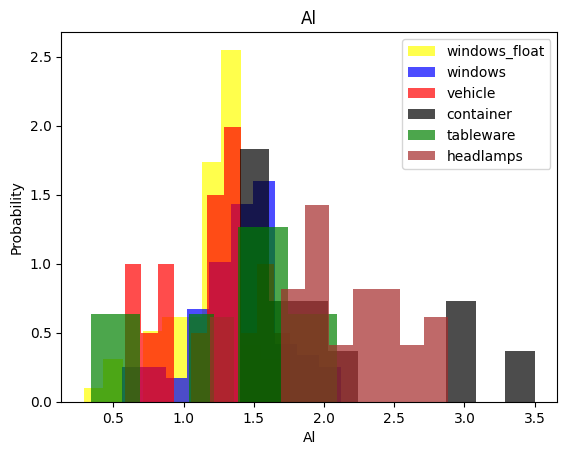

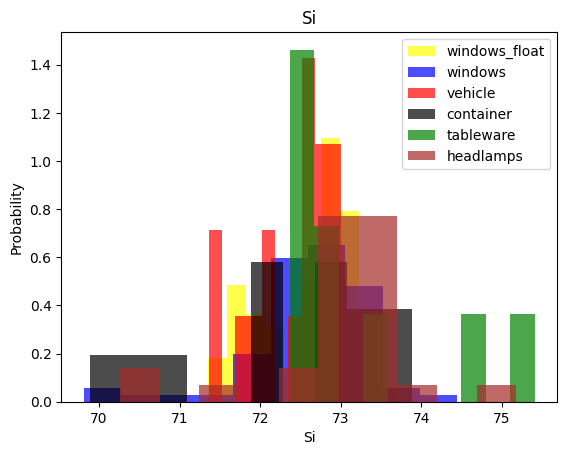

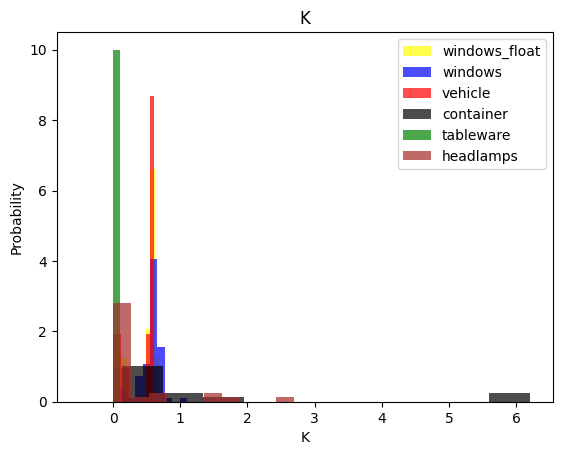

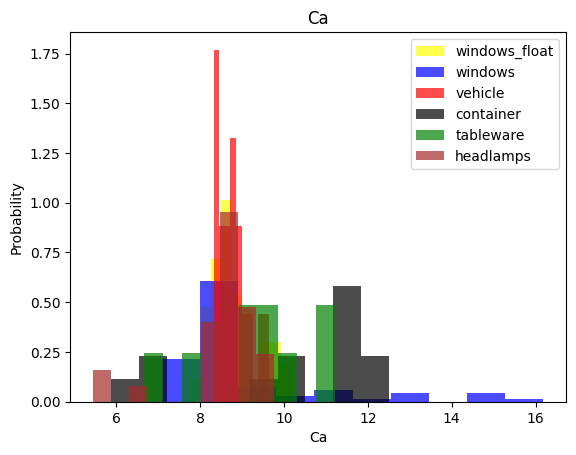

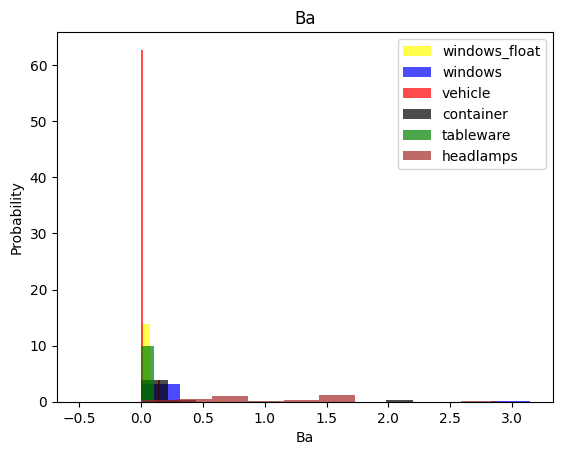

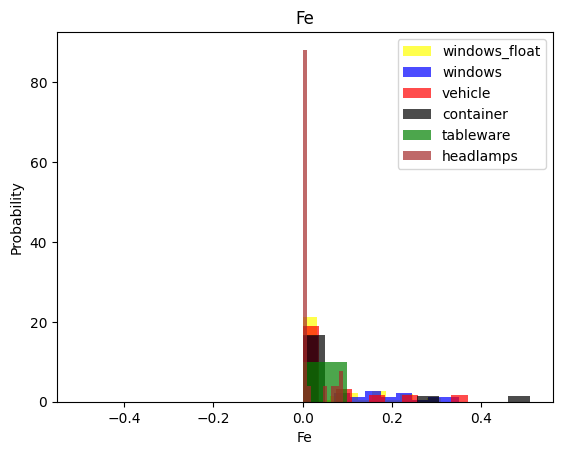

In [ ]:
unique_classes = df[df.columns[-1]].unique()
print(unique_classes)
for label in cols[:-1]:
  plt.hist(df[df["class"]==1][label], color='yellow', label='windows_float', alpha=0.7, density=True)
  plt.hist(df[df["class"]==2][label], color='blue', label='windows', alpha=0.7, density=True)
  plt.hist(df[df["class"]==3][label], color='red', label='vehicle', alpha=0.7, density=True)
  plt.hist(df[df["class"]==5][label], color='black', label='container', alpha=0.7, density=True)
  plt.hist(df[df["class"]==6][label], color='green', label='tableware', alpha=0.7, density=True)
  plt.hist(df[df["class"]==7][label], color='brown', label='headlamps', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

# Train, validation, test datasets

In [ ]:
# First, split the data into training (70%) and temporary (30%) sets
train, temp = train_test_split(df, train_size=0.7, random_state=42, shuffle=True)

# Then, split the temporary set equally into validation and test sets (each 15% of the original data)
valid, test = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)

# Now, train is 70%, valid is 15%, and test is 15% of the original DataFrame


# Scaling
This function scale_dataset is designed to preprocess a given dataset, specifically:

1. Scaling features: It standardizes the features of the dataset to have mean 0 and standard deviation 1.

2. Handling class imbalance (optional): It can oversample the minority class if the oversample parameter is set to True.

scaler = StandardScaler():
Initializes a standard scaler object from scikit-learn, which standardizes features by removing the mean and scaling to unit variance.

X = scaler.fit_transform(X):
Fits the scaler on the data X and then transforms X using this fitted scaler. This will standardize each feature in X.

oversampling:
If oversample is True, it initializes a random oversampler object, RandomOverSampler() from the imbalanced-learn library. This oversampler randomly duplicates some of the samples from the minority class to balance the class distribution. Then, fits the oversampler on the data and then resamples the dataset. After this operation, the dataset will have a balanced class distribution.

data = np.hstack((X, np.reshape(y, (-1, 1)))):
Horizontally stacks the feature matrix X and the reshaped target variable y to reconstruct the full dataset but in the standardized and optionally oversampled format.

In [ ]:
def scale_dataset(dataframe, oversample=False):
    # Extract features from the dataframe: all columns except the last one
    X = dataframe[dataframe.columns[:-1]].values
    # Extract target variable from the dataframe: the last column
    y = dataframe[dataframe.columns[-1]].values
    # Initialize a standard scaler object
    scaler = StandardScaler()
    # Fit the scaler to the data and transform the features to have mean=0 and std deviation=1
    X = scaler.fit_transform(X)

    # Check if oversampling is required
    if oversample:
        # Initialize a random oversampler object for handling class imbalance
        ros = RandomOverSampler()
        # Use the oversampler to balance class distribution by duplicating some minority class samples
        X, y = ros.fit_resample(X, y)

    # Combine the standardized (and optionally oversampled) features and target into one array
    data = np.hstack((X, np.reshape(y, (-1, 1))))

    # Return the combined data, the features, and the target variable
    return data, X, y

train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

# kNN + Classification Report

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred)) # test dataset: 15%

              precision    recall  f1-score   support

           1       0.58      0.78      0.67         9
           2       0.86      0.43      0.57        14
           3       0.00      0.00      0.00         1
           5       0.67      0.67      0.67         3
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         5

    accuracy                           0.64        33
   macro avg       0.60      0.65      0.60        33
weighted avg       0.75      0.64      0.66        33



In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# Implementing K-Fold Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Using cross_val_score to evaluate KNN with K-Fold cross-validation
knn = KNeighborsClassifier(n_neighbors=7)
cross_val_scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')

# Display the cross-validation scores and the mean score
cross_val_scores, cross_val_scores.mean()

(array([0.8125    , 0.703125  , 0.796875  , 0.82539683, 0.65079365]),
 0.7577380952380952)

# ROC curve and VUC

To create an ROC (Receiver Operating Characteristic) curve and compute the AUC (Area Under the Curve), we need to convert the problem into a binary classification problem - generate ROC curves for each class in a multi-class scenario (using the one-vs-rest strategy). Let's proceed with a multi-class ROC curve implementation and calculate the AUC for each class.

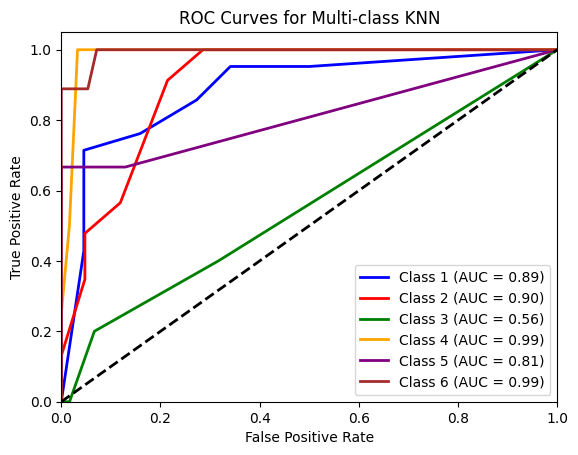

{0: 0.8869047619047619,
 1: 0.901656314699793,
 2: 0.5583333333333333,
 3: 0.985655737704918,
 4: 0.8118279569892473,
 5: 0.9930555555555556}

In [ ]:
df = pd.read_csv(filename, header=None)

# Preview the first few rows of the dataset to understand its structure
df.head()

# Dropping the index column (column 0)
df_clean = df.drop(columns=[0])

# Defining features (X) and target (y)
X = df_clean.drop(columns=[10])  # All features except the last column
y = df_clean[10]  # Target variable (glass class)

# Binarizing the target for multi-class classification
y_binarized = label_binarize(y, classes=[1, 2, 3, 5, 6, 7])
n_classes = y_binarized.shape[1]

# Splitting and scaling the data as before
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementing KNN and using OneVsRestClassifier for multi-class classification
knn = KNeighborsClassifier(n_neighbors=7)
classifier = OneVsRestClassifier(knn)
classifier.fit(X_train_scaled, y_train)

# Predict probabilities for ROC curve
y_score = classifier.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class KNN')
plt.legend(loc="lower right")
plt.show()

roc_auc